In [215]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, MultiPolygon
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
import pymysql
import requests
import sqlite3
import zipfile
from pandas.io import sql
from sqlalchemy import create_engine
import shapely
from shapely.geometry import Polygon, Point, shape
import time
import json

pd.set_option('display.max_columns', 500)

# Analysis plan: need to combine active violation data w/ abandoned mine data


*Active violations:*
* Get last 15% of permit locations from Daniel
* Finish classifying violations as red/yellow/green
* Count number of red (or red + yellow) violations

*Abandoned mines:*
* Select priority 1 & 2 situations (https://amlis.osmre.gov/About.aspx)
* Could weight by total cost of cleanup (if we think more expensive = worse), or % remaining cost (if we think partially cleanup up > not cleaned up at all), and do some weighting scenarios
<p>  </p>
<p>   </p>

To bring these together, we'll weight each occurrence and sum the weighted totals per census tract, and see how different different weightings wind up being. And document the documents that feed into this one, and this document.

# Merging mine permit numbers, violation data, and regulation numbers

In [233]:
#Permit shapefiles, with permit numbers (permits = current permits)
permits = gpd.read_file('permits.shp')
released_permits = gpd.read_file('reviolationrecordsforfoia/relperminfo.shp')

#Aligning CRS
permits = permits.to_crs(released_permits.crs)

#Violations, with permit numbers
viols = pd.read_csv('violations.csv', header=1)
viols = viols.iloc[:-2] #trimming end row

In [234]:
#Exploring permit numbers--seems like Permit column contains a value when PermitNo is sometimes blank
print((permits['Permit'] != permits['PermitNo']).sum()) #only one instance where Permit and PermitNo differ
print((released_permits['Permit'] != released_permits['PermitNo']).sum()) # many instances

1
38


In [235]:
#permits[(permits['Permit'] != permits['PermitNo'])]

In [236]:
#released_permits[(released_permits['Permit'] != released_permits['PermitNo'])]

## Compiling current permits, released permits, permit TransferFr and TransferTo
The permit number listed in the violations dataset may correspond to a permit number (and corresponding geometry) in one of four categories. Combining these different permit numbers allows for a single merge with the violations dataset to cover all available potential permit numbers / geometries.

In [247]:
#extracting key columns, esp permit numbers and geometry
perm_current = permits[['Permit','PermiteeNa','geometry']]
perm_transfr = permits[['TransferFr','PermiteeNa','geometry']]
perm_transto = permits[['TransferTo','PermiteeNa','geometry']]
perm_released = released_permits[['Permit','PermiteeNa','geometry']]
perm_released_tf = released_permits[['TransferFr','PermiteeNa','geometry']]
perm_released_tt = released_permits[['TransferTo','PermiteeNa','geometry']]

In [248]:
#renaming columns
for df in [perm_transfr, perm_transto, perm_released_tf, perm_released_tt]:
    df.columns = ['Permit','PermiteeNa','geometry']

In [249]:
#Identifying source of row
#Not sure why this works but other df loops don't
dfs = [perm_current, perm_transfr, perm_transto, perm_released, perm_released_tf, perm_released_tt]
names = ['Current','Transfr','Transto','Released', 'ReleasedTF', 'ReleasedTT']

for df, name in zip(dfs, names):
    df['Source'] = name

In [250]:
#Data cleaning
def testlengths(dfs):
    for df in dfs:
        print(len(df))
    print("")

dfs = [perm_current, perm_transfr, perm_transto, perm_released, perm_released_tf, perm_released_tt]
testlengths(dfs)

#Getting rid of nan permit numbers    
dfs = [df[~df.Permit.isna()] for df in dfs]
testlengths(dfs)

#Checking for repeated permit numbers, taking perm_current as truth
#Loop setup: https://stackoverflow.com/questions/19290762/cant-modify-list-elements-in-a-loop/19290848#19290848
rep1 = [df[~df.Permit.isin(set(perm_current.Permit.unique()).intersection(set(df.Permit.unique())))] for df in dfs[1:]]
dfs = [dfs[0]] + rep1
testlengths(dfs)

#Checking released TF and released TT dataframes for repeated permit numbers, taking released as true
rep2 = [df[~df.Permit.isin(set(perm_released.Permit.unique()).intersection(set(df.Permit.unique())))] for df in dfs[4:]]
dfs = dfs[:4] + rep2
testlengths(dfs)

290
290
290
1458
1458
1458

290
200
4
1458
817
235

290
199
1
1453
817
206

290
199
1
1453
647
78



In [251]:
#All permit numbers
perm_all = pd.concat(dfs)
perm_all

,Permit,PermiteeNa,geometry,Source
0,1102161,"PARAMONT CONTURA, LLC","MULTIPOLYGON (((10408369.687 3567422.650, 1040...",Current
1,1102059,VIRGINIA FUEL CORPORATION,"POLYGON ((10386171.328 3557116.882, 10386169.8...",Current
2,1202247,"PARAMONT CONTURA, LLC","POLYGON ((10330576.382 3535447.043, 10330584.7...",Current
3,1101401,"RED RIVER COAL COMPANY, INC.","POLYGON ((10268179.992 3574676.537, 10268617.1...",Current
4,1101914,A & G COAL CORPORATION,"MULTIPOLYGON (((10218909.315 3550193.751, 1021...",Current
...,...,...,...,...
1352,1101966,VIRGINIA ENERGY COMPANY,"MULTIPOLYGON (((10468597.500 3721081.500, 1046...",ReleasedTT
1398,1201636,"S. G. COAL COMPANY, INC.","MULTIPOLYGON (((10467587.500 3711736.000, 1046...",ReleasedTT
1442,1201584,WESTMORELAND COAL COMPANY,"POLYGON ((10209556.997 3515182.474, 10209487.3...",ReleasedTT
1446,1101396,"FREEMAN FUELS, INC.","POLYGON ((10295949.384 3599675.000, 10295972.3...",ReleasedTT


In [252]:
#NA names seems fine
perm_all.isna().sum()

Permit         0
PermiteeNa    39
geometry       0
Source         0
dtype: int64

In [253]:
#Checking for duplicate permit numbers
perm_count = perm_all.groupby('Permit').count()
perm_mult = perm_count[perm_count.PermiteeNa > 1].index
dupes = perm_all[perm_all.Permit.isin(perm_mult)].sort_values(by='Permit').reset_index(drop=True)
dupes

,Permit,PermiteeNa,geometry,Source
0,1100204,KNOX CREEK COAL CORPORATION,"POLYGON ((10465378.127 3674189.512, 10465422.3...",Released
1,1100204,KNOX CREEK COAL CORPORATION,"POLYGON ((10464993.500 3673108.000, 10464960.0...",Released
2,1100287,BARNETTE CONTRACTORS,"POLYGON ((10308467.090 3548022.457, 10308163.0...",Released
3,1100287,BARNETTE CONTRACTORS,"POLYGON ((10307260.429 3548679.925, 10307536.4...",Released
4,1100475,"AMOS RIDGE COAL CO., INC.","POLYGON ((10252593.779 3550694.124, 10252586.4...",Released
...,...,...,...,...
254,349701X,"RED RIVER COAL COMPANY, INC.","MULTIPOLYGON (((10260452.539 3562268.416, 1026...",Transfr
255,368701X,"MILLERS COVE ENERGY CO., INC.","POLYGON ((10155437.413 3499160.016, 10155467.1...",ReleasedTF
256,368701X,"MILLERS COVE ENERGY CO., INC.","POLYGON ((10155437.413 3499160.016, 10155467.1...",ReleasedTF
257,369302X,CONSOLIDATION COAL COMPANY,"POLYGON ((10570210.400 3612034.808, 10570183.0...",ReleasedTF


In [254]:
#No duplicates from current permits, as expected (purged all of those)
dupes.groupby('Source').count()

,Permit,PermiteeNa,geometry
Source,,,
Released,74,74,74
ReleasedTF,72,72,72
ReleasedTT,53,53,53
Transfr,59,59,59
Transto,1,1,1


In [257]:
#####I have no way to know which geometry is right if they differ
#To improve, could investigate how different they are or ask DMME for guidance
#Currently just keeping first entry
perm_all = perm_all.drop_duplicates(subset='Permit').reset_index(drop=True)

## Merging violation data with permit (and thus geometry) data

In [388]:
#Joining on perm_all.Permit and viols['Permit #']
viols.rename(columns={'Permit #':'Permit'}, inplace=True)
viol_gdf = viols.merge(perm_all, how='left', on='Permit')

In [389]:
#About 10% of rows are still missing geometries
(viol_gdf.geometry == None).sum() / len(viol_gdf)

0.10358126721763085

### Evaluating violation data

In [390]:
#MM evaluation of violation data to estimate gravity of violation, for weighting data
#Requires expert review--this is MM's own non-expert opinion
#Could also account for length of time elapsed before abatement

#Rough scoring stucture:
#PERMITTING/MGMT ISSUE (3) VS DANGEROUS SITUATION (2) VS ACTUAL OFFSITE IMPACT (1)
regs = pd.read_csv('regulations_sorted_desc_v2.csv')

In [391]:
regs['reg_id'] = regs['reg_id'].astype(str)

In [392]:
#Splitting out regulation column of violation dataframe, to see what regs were violated
reg_split = viol_gdf.loc[:,'Regulation'].str.split('4 VAC 25-130-', expand=True)

for col in reg_split.columns[1:]:
    clean_split = reg_split[col].str.split('(',1)
    cleaner = [x[0] if type(x)==list else x for x in clean_split]  #lose material
    cleanest = [x[0] if type(x) == list else x for x in pd.Series(cleaner).str.split('\n',1)]
    reg_split[col] = cleanest

reg_split.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,,817.41,None,None,None,None,None,None,None,None,None,None,None
1,,817.41,817.41,None,None,None,None,None,None,None,None,None,None
2,,817.41,None,None,None,None,None,None,None,None,None,None,None
3,,817.42,None,None,None,None,None,None,None,None,None,None,None
4,,817.42,None,None,None,None,None,None,None,None,None,None,None


In [393]:
#Reconciling any formatting issues with regulation numbers between violation and reg dfs
s = set()
for col in reg_split.columns:
    s = s.union(reg_split[col].unique())

In [394]:
set(regs.reg_id.unique()).difference(s)

{'800.6',
 '816.1',
 '816.1060000000001',
 '816.1110000000001',
 '816.1310000000001',
 '816.1510000000001',
 '816.18',
 '817.1',
 '817.1110000000001',
 '817.1310000000001',
 '817.1510000000001'}

In [395]:
set(s).difference(regs.reg_id.unique())

{'',
 '4 VAC 25-140-460',
 '800.60',
 '816.100',
 '816.106',
 '816.111',
 '816.131',
 '816.150',
 '816.151',
 '816.180',
 '817.100',
 '817.111',
 '817.131',
 '817.150',
 '817.151',
 None,
 nan}

In [396]:
map_format = {'800.6':'800.60',
 '816.1':'816.100',
 '816.1060000000001':'816.106',
 '816.1110000000001':'816.111',
 '816.1310000000001':'816.131',
 '816.1510000000001':'816.151',
 '816.18':'816.180',
 '817.1':'817.100',
 '817.1110000000001':'817.111',
 '817.1310000000001':'817.131',
 '817.1510000000001':'817.151'}

In [397]:
#Replacing problematic reg_ids (non-exhaustive mapping)
regs.reg_id = regs.reg_id.map(map_format).fillna(regs.reg_id)

In [398]:
#Mapping regulation impact (1,2,3) onto regs
map_impact = regs[['reg_id','eval_MM']].set_index('reg_id').to_dict()['eval_MM']

reg_impact = pd.DataFrame(columns=reg_split.columns[1:])
for col in reg_split.columns[1:]:
    reg_impact[col] = reg_split[col].map(map_impact)

In [399]:
#Calculating impact of violation based on max impact value of regulations violated
#This could be done differently (eg, by averaging); max intended to capture if one+ viols are bad
impact = pd.Series(reg_impact.max(axis=1), name='impact')

In [400]:
#Appending max regulation impact to violation df
viol_gdf = pd.concat([viol_gdf, impact], axis=1)
viol_gdf.head()

,Permit,Unnamed: 1,Company,Area,Inspr,Viol -PS,Viol Dt,Corr Due,Term Dt,Abated,Reference #,Law,Regulation,Description,Action,PermiteeNa,geometry,Source,impact
0,89020.00,NaN,JEWELL SMOKELESS COAL CORPORATION,3,RYH,10238-EF,09/22/15,NaN,09/22/15,NaN,RYH0010155,NaN,4 VAC 25-130-817.41(d)(1),Buchanan County Fox Creek pond SB-1 outfall 00...,Non remedial abatement date second quarter wat...,NaN,None,NaN,1.0
1,0089020,NaN,JEWELL SMOKELESS COAL CORPORATION,3,RYH,10281-SS,12/01/15,01/15/16,01/06/16,NaN,RYH0010259,NaN,4 VAC 25-130-817.41(a)\n4 VAC 25-130-817.41(d)(1),The water monitoring records for 3rd.Qtr. 2015...,Abatement date to clean out the two sediment p...,NaN,None,NaN,1.0
2,0089020,NaN,JEWELL SMOKELESS COAL CORPORATION,3,RYH,10414-EF,04/06/17,05/26/17,05/30/17,NaN,RYH0010924,NaN,4 VAC 25-130-817.41(d)(1),Part 1 of 1 violation: Buchanan County Fox Cre...,The permittee is required to clean out ponds S...,NaN,None,NaN,1.0
3,0089037,NaN,THE BLACK DIAMOND COMPANY,3,JAK,09902-EF,11/07/13,11/21/13,11/19/13,NaN,JAK0000234,NaN,4 VAC 25-130-817.42,I collected a grab sample from the discharge p...,The permittee is required to take the necessar...,NaN,None,NaN,1.0
4,0089038,NaN,"REVELATION ENERGY, LLC",2,JAK,10712-EF,03/19/19,NaN,03/19/19,NaN,JAK0002561,NaN,4 VAC 25-130-817.42,NOV #JAK0002561: A grab sample was obtained f...,This is a non-remedial violation.,NaN,None,NaN,1.0


In [401]:
#Re-gdfing
viol_gdf = gpd.GeoDataFrame(viol_gdf, crs=released_permits.crs)

## AMLIS (abandoned mine reclamation)

In [402]:
#https://amlis.osmre.gov/
amlis = gpd.read_file('AMLIS/Shapefile-ipjeuutg0csofadjb5xiughn.shp')

In [403]:
#Columns clearly have errors, but columns of interest are 'roblem Pri' (problem priority),
#with 1 and 2 being most important.
#Could also weight by "nfunded Co" vs "unded Cost" vs "completed C" (unfunded, funded, and completed
#costs) if cost seems relevant
#Fields listed here: https://amlis.osmre.gov/QueryAdvanced.aspx
amlis.head()

,AMLIS Key,tate/Tribe,County,ongression,uadrangle,Watershed,HUC Code,FIPS Code,Latitude,Longitude,unding Sou,roblem Are,lanning Un,roblem Pri,roblem Typ,ining Type,Ore Types,ate Prepar,ate Revise,rivate Own,tate Owner,ther Feder,ark Servic,orest Serv,ndian Owne,LM Owner %,nfunded St,nfunded Co,nfunded GP,nfunded Me,unded Stan,unded Cost,unded GPRA,unded Metr,ompleted S,ompleted C,ompleted G,ompleted M,geometry
0,VA000001,VA,WISE,9,FLAT GAP,UPPER CLINCH,06010205,51195,37.000000000000,-82.600000000000,SGA,1,1,2,PWHC,P,None,9/17/2008 12:00:00 AM,9/17/2008 12:00:00 AM,0,0,0,0,0,0,0,0.0000000000,0.0000000000,30.0000000000,0.0000000000,0.0000000000,0.0000000000,25.0000000000,0.0000000000,6.0000000000,34065.0000000000,30.0000000000,6.0000000000,POINT (-82.60000 37.00000)
1,VA000001,VA,WISE,9,FLAT GAP,UPPER CLINCH,06010205,51195,37.000000000000,-82.600000000000,SGA,1,1,2,CS,P,None,9/17/2008 12:00:00 AM,9/17/2008 12:00:00 AM,0,0,0,0,0,0,0,0.6000000000,37000.0000000000,5.0000000000,0.9700000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,POINT (-82.60000 37.00000)
2,VA000002,VA,WISE,9,FLAT GAP,UPPER LEVISA,05070202,51195,37.000000000000,-82.600000000000,SGA,2,1,2,PWHC,S,None,11/19/2004 12:00:00 AM,11/19/2004 12:00:00 AM,100,0,0,0,0,0,0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,5.0000000000,10448.0000000000,25.0000000000,5.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,POINT (-82.60000 37.00000)
3,VA000002,VA,WISE,9,FLAT GAP,UPPER LEVISA,05070202,51195,37.000000000000,-82.600000000000,SGA,2,1,3,H,S,None,11/19/2004 12:00:00 AM,11/19/2004 12:00:00 AM,100,0,0,0,0,0,0,8000.0000000000,2000000.0000000000,114.2900000000,2438.4000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,POINT (-82.60000 37.00000)
4,VA000002,VA,WISE,9,FLAT GAP,UPPER LEVISA,05070202,51195,37.000000000000,-82.600000000000,SGA,2,1,2,CSL,S,None,11/19/2004 12:00:00 AM,11/19/2004 12:00:00 AM,100,0,0,0,0,0,0,59.0000000000,1407032.0000000000,59.0000000000,23.8800000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,19.0000000000,985714.0000000000,19.0000000000,7.6900000000,POINT (-82.60000 37.00000)


In [404]:
#Setting CRS--guessing it's WGS84
## Need to check on this
amlis.crs = "EPSG:4326"

In [444]:
#Subsetting to top-priority issues
amlis_priority = amlis[amlis['roblem Pri'].isin(['1','2'])].reset_index(drop=True)

In [445]:
amlis_priority.shape

(2063, 39)

In [446]:
#Checking for missing rows
amlis_priority.isna().geometry.sum()

0

## Mapping and impact estimation

In [411]:
#Loading VA census tracts
va = gpd.read_file('tl_2019_51_tract/tl_2019_51_tract.shp')

#Aligning CRS and trimming missing geometry rows from violations df
viol_gdf = viol_gdf[viol_gdf.geometry != None]
viol_gdf = viol_gdf.to_crs(va.crs)

amlis_priority = amlis_priority.to_crs(va.crs)

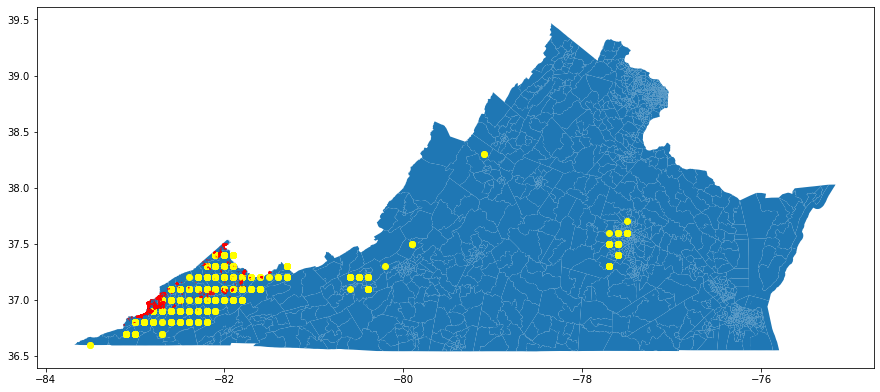

In [412]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
va.plot(ax=ax)
amlis_priority.plot(ax=ax, color='yellow')
viol_gdf.plot(ax=ax, color='red')

(36.5, 38)

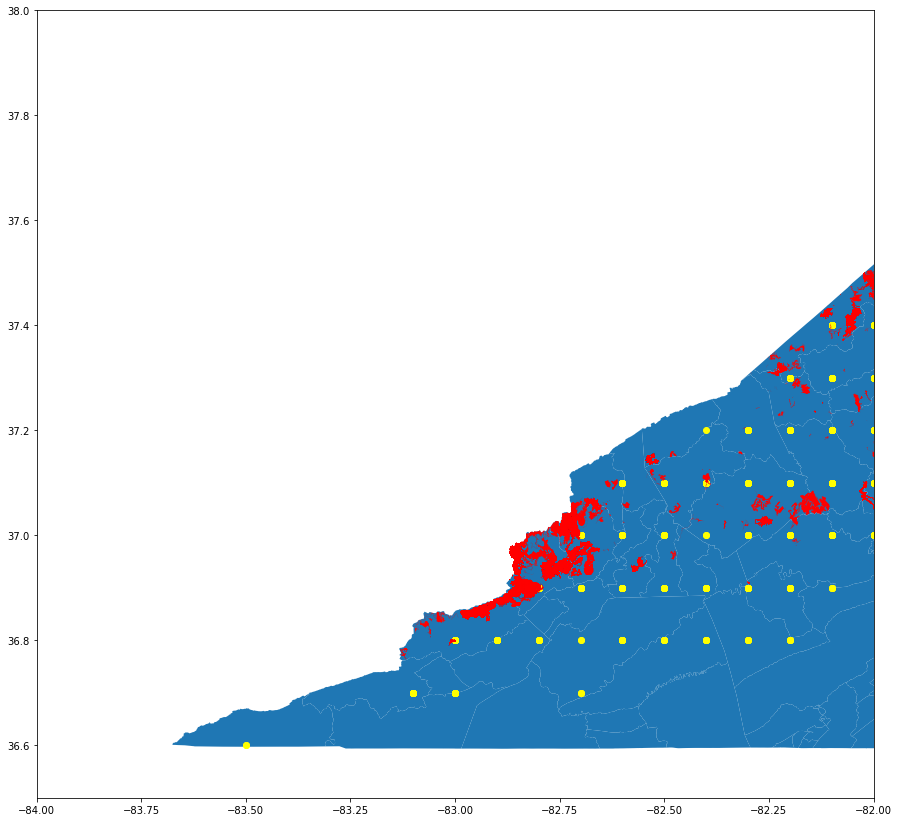

In [420]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
va.plot(ax=ax)
amlis_priority.plot(ax=ax, color='yellow')
viol_gdf.plot(ax=ax, color='red')

ax.set_xlim([-84,-82])
ax.set_ylim([36.5, 38])

### Estimating impact

In [423]:
#Subsetting violation data for ease of use
viol_sub = viol_gdf[['Permit','Company','impact','geometry']].reset_index(drop=True)
viol_sub = viol_sub.reset_index()
viol_sub['viol_ID'] = viol_sub['index'].apply(lambda x:'viol_'+str(x))
viol_sub.drop(columns='index', inplace=True)

In [426]:
#From active violation data: polygon overlay to capture if violation permit spans two census tracts
viol_intersect = gpd.overlay(viol_sub, va, how='intersection')

In [428]:
viol_intersect.head()

,Permit,Company,impact,viol_ID,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,1100024,"RED RIVER COAL COMPANY, INC.",2.0,viol_0,51,195,931000,51195931000,9310,Census Tract 9310,G5020,S,155530905,715470,+36.9794128,-082.6658330,"POLYGON ((-82.64940 37.03286, -82.64955 37.032..."
1,1100024,"RED RIVER COAL COMPANY, INC.",2.0,viol_1,51,195,931000,51195931000,9310,Census Tract 9310,G5020,S,155530905,715470,+36.9794128,-082.6658330,"POLYGON ((-82.64940 37.03286, -82.64955 37.032..."
2,1100024,"RED RIVER COAL COMPANY, INC.",3.0,viol_2,51,195,931000,51195931000,9310,Census Tract 9310,G5020,S,155530905,715470,+36.9794128,-082.6658330,"POLYGON ((-82.64940 37.03286, -82.64955 37.032..."
3,1100033,"RED RIVER COAL COMPANY, INC.",2.0,viol_3,51,195,931000,51195931000,9310,Census Tract 9310,G5020,S,155530905,715470,+36.9794128,-082.6658330,"MULTIPOLYGON (((-82.67122 37.03693, -82.67106 ..."
4,1100033,"RED RIVER COAL COMPANY, INC.",1.0,viol_4,51,195,931000,51195931000,9310,Census Tract 9310,G5020,S,155530905,715470,+36.9794128,-082.6658330,"MULTIPOLYGON (((-82.67122 37.03693, -82.67106 ..."


In [447]:
#AMLIS: because geo data is highly imprecise, adding 3-km buffer to help account for fuzziness
#Re-projecting to projected CRS: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/geographic-vs-projected-coordinate-reference-systems-python/
#https://epsg.io/3968
amlis_priority = amlis_priority.to_crs('EPSG:3968')
amlis_priority.geometry = amlis_priority.geometry.buffer(3000)
amlis_priority = amlis_priority.to_crs(va.crs)

(36.5, 38)

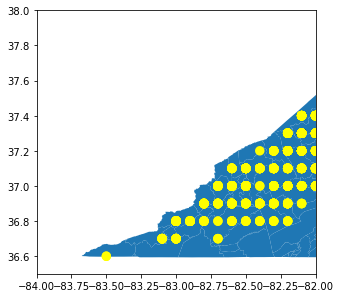

In [449]:
#Gut check for buffer size
fig, ax = plt.subplots(1,1,figsize=(5,5))
va.plot(ax=ax)
amlis_priority.plot(ax=ax, color='yellow')

ax.set_xlim([-84,-82])
ax.set_ylim([36.5, 38])

In [452]:
#Labeling amlis
amlis_priority.reset_index(inplace=True)
amlis_priority['amlis_ID'] = amlis_priority['index'].apply(lambda x:'amlis_'+str(x))
amlis_priority.drop(columns='index', inplace=True)

In [453]:
#AMLIS intersection: which census tracts do AMLIS sites touch?
amlis_intersect = gpd.overlay(amlis_priority, va, how='intersection')

In [454]:
amlis_intersect.head()

,AMLIS Key,tate/Tribe,County,ongression,uadrangle,Watershed,HUC Code,FIPS Code,Latitude,Longitude,unding Sou,roblem Are,lanning Un,roblem Pri,roblem Typ,ining Type,Ore Types,ate Prepar,ate Revise,rivate Own,tate Owner,ther Feder,ark Servic,orest Serv,ndian Owne,LM Owner %,nfunded St,nfunded Co,nfunded GP,nfunded Me,unded Stan,unded Cost,unded GPRA,unded Metr,ompleted S,ompleted C,ompleted G,ompleted M,amlis_ID,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,VA000001,VA,WISE,9,FLAT GAP,UPPER CLINCH,06010205,51195,37.000000000000,-82.600000000000,SGA,1,1,2,PWHC,P,None,9/17/2008 12:00:00 AM,9/17/2008 12:00:00 AM,0,0,0,0,0,0,0,0.0000000000,0.0000000000,30.0000000000,0.0000000000,0.0000000000,0.0000000000,25.0000000000,0.0000000000,6.0000000000,34065.0000000000,30.0000000000,6.0000000000,amlis_0,51,195,930800,51195930800,9308,Census Tract 9308,G5020,S,117736236,751313,+37.0851145,-082.6735007,"POLYGON ((-82.62238 37.02020, -82.62225 37.020..."
1,VA000001,VA,WISE,9,FLAT GAP,UPPER CLINCH,06010205,51195,37.000000000000,-82.600000000000,SGA,1,1,2,CS,P,None,9/17/2008 12:00:00 AM,9/17/2008 12:00:00 AM,0,0,0,0,0,0,0,0.6000000000,37000.0000000000,5.0000000000,0.9700000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,amlis_1,51,195,930800,51195930800,9308,Census Tract 9308,G5020,S,117736236,751313,+37.0851145,-082.6735007,"POLYGON ((-82.62238 37.02020, -82.62225 37.020..."
2,VA000002,VA,WISE,9,FLAT GAP,UPPER LEVISA,05070202,51195,37.000000000000,-82.600000000000,SGA,2,1,2,PWHC,S,None,11/19/2004 12:00:00 AM,11/19/2004 12:00:00 AM,100,0,0,0,0,0,0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,5.0000000000,10448.0000000000,25.0000000000,5.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,amlis_2,51,195,930800,51195930800,9308,Census Tract 9308,G5020,S,117736236,751313,+37.0851145,-082.6735007,"POLYGON ((-82.62238 37.02020, -82.62225 37.020..."
3,VA000002,VA,WISE,9,FLAT GAP,UPPER LEVISA,05070202,51195,37.000000000000,-82.600000000000,SGA,2,1,2,CSL,S,None,11/19/2004 12:00:00 AM,11/19/2004 12:00:00 AM,100,0,0,0,0,0,0,59.0000000000,1407032.0000000000,59.0000000000,23.8800000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,19.0000000000,985714.0000000000,19.0000000000,7.6900000000,amlis_3,51,195,930800,51195930800,9308,Census Tract 9308,G5020,S,117736236,751313,+37.0851145,-082.6735007,"POLYGON ((-82.62238 37.02020, -82.62225 37.020..."
4,VA000003,VA,WISE,9,FLAT GAP,UPPER LEVISA,05070202,51195,37.000000000000,-82.600000000000,SGA,3,1,2,PWHC,S,None,9/17/2008 12:00:00 AM,9/17/2008 12:00:00 AM,0,0,0,0,0,0,0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,21.0000000000,43880.0000000000,105.0000000000,21.0000000000,24.0000000000,136259.0000000000,120.0000000000,24.0000000000,amlis_4,51,195,930800,51195930800,9308,Census Tract 9308,G5020,S,117736236,751313,+37.0851145,-082.6735007,"POLYGON ((-82.62238 37.02020, -82.62225 37.020..."


In [455]:
amlis_intersect.shape

(5524, 52)

In [459]:
sub_amlis = amlis_intersect[['amlis_ID','GEOID','roblem Pri']]

In [460]:
sub_viol = viol_intersect[['viol_ID','GEOID','impact']]

In [461]:
for df in [sub_amlis, sub_viol]:
    df.columns = ['problem_id','GEOID','score']

In [471]:
#Gathering impacts and their associated GEOIDs
impact = pd.concat([sub_amlis, sub_viol]).reset_index(drop=True)

In [484]:
#Dropping NaNs and converting score to integer
impact = impact[~impact['score'].isna()].reset_index(drop=True)
impact.score = impact.score.astype(int)

In [490]:
#Converting score from int to letter to make easier to weight
map_weight = {1:'A',2:'B',3:'C'}
impact.score = impact.score.map(map_weight)

In [494]:
#Counting category A as 2, B as 1, C as 0
map_weight2 = {'A':2, 'B':1, 'C':0}
impact['score_num'] = impact.score.map(map_weight2)

In [497]:
#Getting total score by GEOID
impact_sum = impact.groupby('GEOID').sum().reset_index()

In [499]:
#Bringing in census tract GEOIDs
impact_sum = impact_sum.merge(va[['GEOID','geometry']], on='GEOID', how='left')

In [502]:
impact_sum = gpd.GeoDataFrame(impact_sum, crs=va.crs)

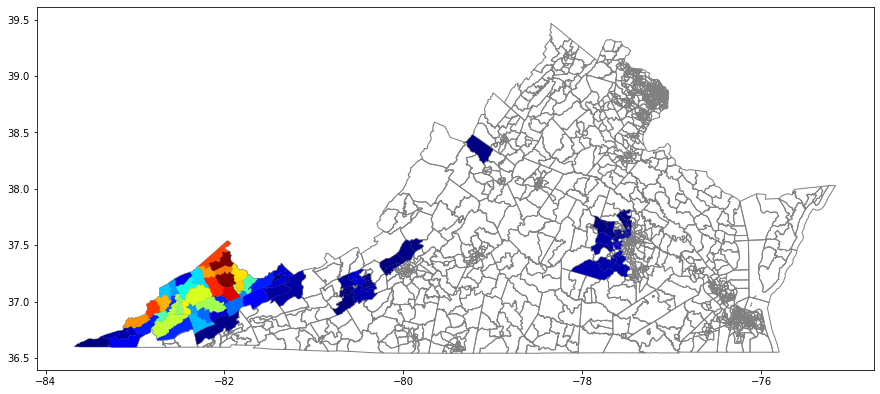

In [503]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
va.plot(ax=ax, color='none', edgecolor='gray')
impact_sum.plot(ax=ax, cmap='jet',column='score_num')